## Module 2: classification
## Week 1
# Predicting sentiment from product reviews


In [1]:
# Import used modules
import pandas as pd
import numpy as np
import zipfile
import os
import glob
import string
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import linear_model
%matplotlib inline

In [2]:
# Choose a theme
%matplotlib inline
plt.style.available

[u'seaborn-darkgrid',
 u'seaborn-notebook',
 u'classic',
 u'seaborn-ticks',
 u'grayscale',
 u'bmh',
 u'seaborn-talk',
 u'dark_background',
 u'ggplot',
 u'fivethirtyeight',
 u'seaborn-colorblind',
 u'seaborn-deep',
 u'seaborn-whitegrid',
 u'seaborn-bright',
 u'seaborn-poster',
 u'seaborn-muted',
 u'seaborn-paper',
 u'seaborn-white',
 u'seaborn-pastel',
 u'seaborn-dark',
 u'seaborn-dark-palette']

In [3]:
plt.style.use('ggplot')

In [4]:
# Extract all zips in the folder data sets
for root, dirs, files in os.walk("./datasets", topdown=False):
    zip_files = glob.glob(root + '/*.zip')
    print("Unzipped:")
    print(zip_files)
    for zip_filename in zip_files:
        dir_name = os.path.splitext(zip_filename)[0]
        zip_handler = zipfile.ZipFile(zip_filename, "r")
        zip_handler.extractall(root)

Unzipped:
['./datasets\\amazon_baby.csv.zip']


In [5]:
# read from csv and dump to Pandas DataFrame
products = pd.read_csv('./datasets/amazon_baby.csv')

In [6]:
products.describe()

,rating
count,183531.000000
mean,4.120448
std,1.285017
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


In [7]:
# how many null per field?
products[products.isnull().any(axis=1)].isnull().sum()
products.shape

(183531, 3)

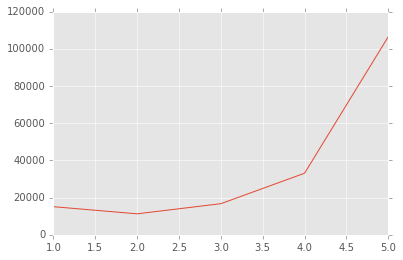

In [8]:
# So we can see that the data set has 3 columns (name, review and rating)
# count of reviews by ratings
count_by_rating = products[['rating', 'review']].groupby(['rating']).agg(['count'])
plt.plot(count_by_rating)

In [9]:
# fill in N/A's in the review column
products = products.fillna({'review':''}) 

In [10]:
# remove punctuation characters
def remove_punctuation(text):
    import string
    text = str(text)
    return text.translate(None, string.punctuation) 

products['review_clean'] = products['review'].apply(remove_punctuation)
products.ix[234:237]
products.shape

(183531, 4)

In [11]:
# ignore rating = 3, neutral, may not have sentiment
products = products[products['rating'] != 3]
products.shape

(166752, 4)

In [12]:
# positive / negative sentiment
products['sentiment'] = products['rating'].apply(lambda rating : +1 if rating > 3 else -1)
print("Size of 'products' is {0}".format(products.shape))

Size of 'products' is (166752, 5)


In [13]:
# load and clean review of train and test sets
train_data_idx = pd.read_json('datasets/module-2-assignment-train-idx.json')
test_data_idx = pd.read_json('datasets/module-2-assignment-test-idx.json')

train_data = products.iloc[train_data_idx.T,:]
test_data = products.iloc[test_data_idx.T,:]

print("Size of 'train_data' is {0}".format(train_data.shape))
print("Size of 'test_data' is {0}".format(test_data.shape))
print("Ratio training/test = %.2f%%" % (100*test_data.shape[0]/(test_data.shape[0]+train_data.shape[0])))

Size of 'train_data' is (133416, 5)
Size of 'test_data' is (33336, 5)
Ratio training/test = 19.00%


In [14]:
# number of nan values in train dataset
train_data[train_data.isnull().any(axis=1)].isnull().sum()

name            260
review            0
rating            0
review_clean      0
sentiment         0
dtype: int64

In [15]:
# number of nan values in test dataset
test_data[test_data.isnull().any(axis=1)].isnull().sum()

name            46
review           0
rating           0
review_clean     0
sentiment        0
dtype: int64

#### Build the word count vector for each review

A vector consisting of word counts is often referred to as bag-of-word features. Since most words occur in only a few reviews, word count vectors are sparse. For this reason, scikit-learn and many other tools use sparse matrices to store a collection of word count vectors. Refer to appropriate manuals to produce sparse word count vectors. General steps for extracting word count vectors are as follows:
- Learn a vocabulary (set of all words) from the training data. Only the words that show up in the training data will be considered for feature extraction.
- Compute the occurrences of the words in each review and collect them into a row vector.
- Build a sparse matrix where each row is the word count vector for the corresponding review. Call this matrix train_matrix.
- Using the same mapping between words and columns, convert the test data into a sparse matrix test_matrix.

In [16]:
# tokenize reviews
vectorizer = CountVectorizer(token_pattern=r'\b\w+\b')
     # Use this token pattern to keep single-letter words
# First, learn vocabulary from the training data and assign columns to words
# Then convert the training data into a sparse matrix
train_matrix = vectorizer.fit_transform(train_data['review_clean'])
# Second, convert the test data into a sparse matrix, using the same word-column mapping
test_matrix = vectorizer.transform(test_data['review_clean'])


In [17]:
len(vectorizer.get_feature_names())

122046

#### Train a sentiment classifier with logistic regression

We will now use logistic regression to create a sentiment classifier on the training data. This model will use the column word_count as a feature and the column sentiment as the target. We will use validation_set=None to obtain same results as everyone else.

In [18]:
logreg = linear_model.LogisticRegression()
sentiment_model = logreg.fit(train_matrix, train_data["sentiment"])
weights_list = list(sentiment_model.intercept_) + list(sentiment_model.coef_.flatten())
weights_sent_model = np.array(weights_list, dtype = np.double)
print len(weights_sent_model)

122047


In [19]:
num_positive_weights = len(weights_sent_model[weights_sent_model >= 0.0])
num_negative_weights = len(weights_sent_model[weights_sent_model < 0.0])

print "Number of positive weights: %i" % num_positive_weights
print "Number of negative weights: %i" % num_negative_weights

Number of positive weights: 87499
Number of negative weights: 34548


#### Making predictions with logistic regression

In [20]:
sample_test_data = test_data.ix[[59,71,91]]
print sample_test_data['rating']
sample_test_data

59    5
71    2
91    1
Name: rating, dtype: int64


,name,review,rating,review_clean,sentiment
59,Our Baby Girl Memory Book,Absolutely love it and all of the Scripture in...,5,Absolutely love it and all of the Scripture in...,1
71,Wall Decor Removable Decal Sticker - Colorful ...,Would not purchase again or recommend. The dec...,2,Would not purchase again or recommend The deca...,-1
91,New Style Trailing Cherry Blossom Tree Decal R...,Was so excited to get this product for my baby...,1,Was so excited to get this product for my baby...,-1


In [21]:
# let's read 
sample_test_data['review'].ix[59]

'Absolutely love it and all of the Scripture in it.  I purchased the Baby Boy version for my grandson when he was born and my daughter-in-law was thrilled to receive the same book again.'

In [22]:
# remember that the domain of the logistic function is -inf,+inf. from 0 to the right are the positive reviews
sample_test_matrix = vectorizer.transform(sample_test_data['review_clean'])
# classifier is a logistic function
scores = sentiment_model.decision_function(sample_test_matrix)
print scores

[  5.91795278  -3.55032445 -10.22933849]


In [23]:
# 3 reviews, tokenized, count of each word. each column in the pack the bag of all words from the training dataset
sample_test_matrix.shape

(3, 122046)

In [24]:
print("Real sentiment calculated from rating (-1 if rating<3): {0}".format(sample_test_data['sentiment'].tolist()))
print("Predicted sentiments: {0}".format(sentiment_model.predict(sample_test_matrix)))

Real sentiment calculated from rating (-1 if rating<3): [1, -1, -1]
Predicted sentiments: [ 1 -1 -1]


#### Find the most positive (and negative) review

In [25]:
sample_test_matrix = vectorizer.transform(test_data['review_clean'])
# classifier is a logistic function
scores = sentiment_model.decision_function(sample_test_matrix)

In [47]:
highest_score_index = np.argmax(scores)
print("Highest predicted score ({0}, {1}):".format(highest_score_index, test_data['name'].iloc[highest_score_index]))
test_data['review_clean'].iloc[highest_score_index]

Highest predicted score (7678, Evenflo Portable Ultrasaucer):


'I did a lot of research before buying this Ultrasaucer for my 5monthold son  I have to say that unlike the other quotwalkersquot that I purchased in the past for my daughters this one gets 5 stars from me  Here are some of my favorite featuresIts portable  The legs collapse EASILY to let it fit in between the seats of your car or even the smallest of trunks  A great way to take it camping or to Grandmas house  It even has a carrying handle to make it even easier  Id say that when folded its about 10 inches thick so you dont need to own a minivan or SUV to transport it inChock full of toys at a decent size  Some of the others that we looked at had a lot of wasted space on the play bar  This one has literally crammed as many toys as possible onto the play area keeping baby entertained longer  The great use of space on this item keeps it from being as gigantic as some of the deluxe saucers out there which is great in our large but narrow living roomGreat teethers  My son loves the fact t

In [81]:
lowest_score_index = np.argmin(scores)
print("Lowest predicted score ({0} {1}):".format(lowest_score_index, test_data['name'].iloc[lowest_score_index]))
test_data['review_clean'].iloc[lowest_score_index]

Lowest predicted score (9315 Arms Reach Co-Sleeper brand Mini Co-Sleeper Bassinet - Natural):


'Please see my email to the companyHelloI am writing to voice my familys anger over your unsafe cheap cosleeper  If you recall I had a problem with my newly purchased cosleeper back in May which I immediately called about and was told to send the frame back  At that time I asked to speak to a supervisor about the situation and was told that I would be contacted shortly  However Mayra was the only one who I was able to speak with after numerous attempts to be put in contact with the supervisor  After a huge delay due to mistakes on your end I finally got the cosleeper sent back to the company after speaking with Veronica on June 13thAt this time June 13th I asked to speak with the manager of the company and Veronica told me that Sharon was not in at the time but would be in later that day  I obviously never heard from Sharon or anyone else from this company for that matter from that point on  I was inquiring to speak with the manager after voicing my concern over just repairing the fram

In [54]:
test_data.iloc[[highest_score_index, lowest_score_index]]

,name,review,rating,review_clean,sentiment
8384,Evenflo Portable Ultrasaucer,I did a lot of research before buying this Ult...,5,I did a lot of research before buying this Ult...,1
10180,Arms Reach Co-Sleeper brand Mini Co-Sleeper Ba...,"Please see my email to the company:Hello,I am ...",1,Please see my email to the companyHelloI am wr...,-1
